In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
import matplotlib.pyplot as pl
import scipy.stats as st
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.mplot3d import Axes3D

#font = {'family' : 'normal',
#        'weight' : 'bold',
#        'size'   : 11}
#'weight' : 'bold',
#mpl.rc('font', **font)

In [2]:
dist_numpy = np.load('./ic_chan2_1_combined_all_feb21cpu_plotfeb28_numpy_posterior.npy')
rmh_numpy = np.load('./rmh_prior_chan_2-numpy.npy')
ground = np.load('./gt_chan2_1.npy')

In [3]:
num_traces =  dist_numpy.shape[0]
num_traces_rmh =  rmh_numpy.shape[0]

In [6]:
def plot_dist(chan=2,run=0,index=0):
#    chan=22
    if chan==2: ic_integrals=[218,156,2808,38,2013,396,1694,1520 , 1475, 4429, 39.68]
    if chan==22:  ic_integrals=[1,47.52,395.12,1078.27,138.51,60.58]
    experiment='Apr12_hpo_lstm_dim_512_lstm_depth_1_proposal_mixture_components_5'
#    experiment='Apr25_hpo_lstm_dim_512_lstm_depth_1_proposal_mixture_components_5_ReallyReRunAddressSmall'
#    experiment='Apr25_hpo_lstm_dim_512_lstm_depth_1_proposal_mixture_components_5_ReallyReRunAddress'
#    experiment='nopriorinflate_may_2019'
    try: 
        dist_numpy = np.load('/Users/wbhimji/Data/etalumis-bkp/ic_posteriors-parallel-combined/{experiment}_chan{chan}_{run}-numpy_posterior.npy'.format(experiment=experiment,run=run,chan=chan))
#        dist_numpy = np.load('/global/cscratch1/sd/wbhimji/etalumis_data_dec7_2018/plots/ic_posteriors-parallel-combined/singleIC_chan2_2_13344768_7-numpy_posterior.npy'.format(experiment=experiment,run=run,chan=chan))        
        rmh_numpy = np.load('/Users/wbhimji/Data/etalumis-bkp/ic_posteriors-parallel-combined/Apr25_rmh_gt_chan{chan}_{run}-numpy.npy'.format(run=run,chan=chan))
    except:
        print('problem loading')
        return
#    rmh_numpy = np.load('/global/cscratch1/sd/wbhimji/etalumis_data_dec7_2018/plots/ic_posteriors-parallel-combined/Apr25_rmh_gt_chan2_%s-numpy.npy' % run )
   
    ground = np.load('/Users/wbhimji/Data/etalumis-bkp/etalumis_data_dec7_2018/numpys/gt_Apr25_chan{chan}_{run}.npy'.format(run=run,chan=chan))

    num_traces =  dist_numpy.shape[0]
    num_traces_rmh =  rmh_numpy.shape[0]

    ground_truth_trace='/global/cscratch1/sd/wbhimji/etalumis_data_dec7_2018/plots/gt_chan2_1.npy'

    def nhad_nem_ninvis(pids,viz):
        n_em      = np.sum([1 if abs(p) in [22,11] else 0 for p in pids])
        n_had     = np.sum([1 if abs(p)>100 else 0 for p in pids])
        n_calovis = np.sum(viz)
        n_invis   = np.sum(1-viz)
        assert n_em + n_had + n_invis == len(pids)
        return [n_em,n_had,n_calovis,n_invis]

    mother           = dist_numpy[:,:3]
    mother_rmh       = rmh_numpy[:,:3]
    channel          = dist_numpy[:,3]
    channel_rmh      = rmh_numpy[:,3]
    final            = dist_numpy[:,4:4+(30*8)].reshape(num_traces,30,8)
    final_rmh            = rmh_numpy[:,4:4+(30*8)].reshape(num_traces_rmh,30,8)
    finalfilt        = [np.array(sorted(f[f>-9999].reshape(-1,8), key=lambda x: -x[3])) for f in final]
    finalfilt_rmh        = [np.array(sorted(f[f>-9999].reshape(-1,8), key=lambda x: -x[3])) for f in final_rmh]
    finalmult        = np.array([f.shape[0] for f in finalfilt])
    obs              = dist_numpy[:,4+(30*8):].reshape(num_traces,35,35,20)
    particle_types   = np.array([nhad_nem_ninvis(f[:,6],f[:,7]) for f in finalfilt])
    if ground is not None:
                g_mother         = ground[:3]
                g_channel        = ground[3]
                g_final          = ground[4:4+(30*8)].reshape(30,8)
                g_finalfilt      = np.array(sorted(g_final[g_final>-9999].reshape(-1,8), key=lambda x: -x[3]))
                g_finalmult      = g_finalfilt.shape[0]
                g_obs            = ground[4+(30*8):].reshape(35,35,20)
                g_particle_types = nhad_nem_ninvis(g_finalfilt[:,6],g_finalfilt[:,7])

    ax1 = plt.subplot2grid(shape, (index, 0))
    ax2 = plt.subplot2grid(shape, (index, 1))
    ax3 = plt.subplot2grid(shape, (index, 2))

    motheraxes = [ax1,ax2,ax3]
#    channelax   = plt.subplot2grid(shape, (1, 1), colspan=2) 
    channelax   = plt.subplot2grid(shape, (index, 6), colspan=1)        

            # ## tau momentum
    axarr = motheraxes
    colors = mpl.cm.inferno(np.linspace(0,1,5))[1:-1]

    titles = ['τ px','τ py','τ pz']
    limits = [[-3,3],[-3,3],[43,47]]

    energies = np.array([f[:2] for f in finalfilt])
    energies_rmh = np.array([f[:2] for f in finalfilt_rmh])

    def make_met(fin):
        x = []
        for e in fin:
            filtered = e[e[:,-1]>-9999]
            mom = np.sum([f for f in filtered if not f[-1]], axis=0)
            met = np.sqrt(mom[0]**2 + mom[1]**2)
            x.append(met)
        return np.asarray(x)
    

    def draw_contour(ax,datasets,color, style = 'dotted',label='IC'):
        x = datasets[0]
        y = datasets[1]
        xmin, xmax = 0,40
        ymin, ymax = 0,40
        xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
        positions = np.vstack([xx.ravel(), yy.ravel()])
        values = np.vstack([x, y])
        kernel = st.gaussian_kde(values)
        f = np.reshape(kernel(positions).T, xx.shape)
        cset = ax.contour(xx, yy, f, colors=color, levels = [2e-3,5e-3,2e-2], linestyles = style, alpha = 1.0,label=label)
        return cset

    def observable_set(ax,title,datasets,ground_truth, bins, color, xlabel):
        integrals = [ic_integrals[run], 2000]
        counts_list = [np.histogram(d, bins = bins)[0] for d in datasets]
        counts_list = [c/np.sum(c)*intg for intg,c in zip(integrals,counts_list)]

        binwidth = (bins[1:]-bins[:-1])[0]
        centers  = bins[:-1]+(bins[1:]-bins[:-1])/2.
        errs_heights = [(np.sqrt(c)/np.sum(c)/binwidth, c/np.sum(c)/binwidth) for c in (counts_list)]

        h1,_,_ = ax.hist(datasets[0], bins = bins, facecolor = color, edgecolor = color, density=True, fill=True, alpha = 0.5, histtype='step',label='IC')
        h2,_,_ = ax.hist(datasets[1], bins = bins, facecolor = color, edgecolor = color, density=True, fill=False, alpha = 0.5, histtype='step',label='RMH')

        maxy = 1.2*np.max(h1)

        l = ax.vlines(ground_truth,0,10, linestyles='dashed')
        ax.set_ylim(0,maxy)
        ax.set_xlim(min(bins),max(bins))
        ax.legend()
        if (index==0): ax.set_title(title)
        if ((shape[0]-index)==1): ax.set_xlabel(xlabel)
        for err,hei in errs_heights:
            ax.bar(centers, hei, yerr = err, width = binwidth, linewidth = 0, fill = None, alpha = 0.2, ecolor = color, xerr = binwidth/2.)
    #     ax.bar(centers, [h for h,_ in errs_heights])

    met = make_met(final)
    met_rmh = make_met(final_rmh)

    for i in [0,1,2]:
        axarr[i].clear()
        observable_set(axarr[i],
            title = titles[i],
            ground_truth = g_mother[i],
            color = colors[i],
            datasets = [
            mother[:,i],
            mother_rmh[:,i]
        ], bins = np.linspace(limits[i][0],limits[i][1],21), xlabel = 'Momentum [GeV/c]')


    ax4 = plt.subplot2grid(shape, (index, 3))
    observable_set(ax4,
        title = 'FSP Energy {}'.format(0 + 1),
        ground_truth = g_finalfilt[:3][0,3],
        color = 'blue',
        datasets = [
        energies[:,0,3],
        energies_rmh[:,0,3]
    ], bins = np.linspace(0,40,21), xlabel = 'Energy [GeV]')


    ax5 = plt.subplot2grid(shape, (index, 4))
    observable_set(ax5,
        title = 'FSP Energy {}'.format(1 + 1),
        ground_truth = g_finalfilt[:3][1,3],
        color = 'blue',
        datasets = [
        energies[:,1,3],
        energies_rmh[:,1,3]
    ], bins = np.linspace(0,40,21), xlabel = 'Energy [GeV]')

    ax = channelax
    ch = ax.hist(channel, np.linspace(-0.5,35.5,37), density=True, fill=True, facecolor = 'grey',alpha=0.5,edgecolor='grey',label='IC')
    ch = ax.hist(channel_rmh, np.linspace(-0.5,35.5,37), density=True,  fill=False, facecolor = 'grey',alpha=0.5, label='RMH')
    if ground_truth_trace is not None:
        l = ax.vlines(g_channel,0,1.0, linestyles='dashed')
    ax.set_ylim(0.,1.0)
    ax.set_xlim(-1, 35)
    # ax.legend([l,ch[2][0]],['ground truth','posterior'])
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    if (index==0): ax.set_title('Decay Channel')
    ax.legend()

    ax_ctr = plt.subplot2grid(shape, (index, 5))
    cntr1 = draw_contour(ax_ctr, datasets = [energies[:,0,3],energies[:,1,3]], color = 'blue', style = 'solid',label = 'IC')
    cntr2 = draw_contour(ax_ctr, datasets = [energies_rmh[:,0,3],energies_rmh[:,1,3]], color = 'r', style = 'solid',label = 'RMH')
    plt.scatter([g_finalfilt[:3][0,3]],[g_finalfilt[:3][1,3]], marker = 'x', c = 'k')
    h1,_ = cntr1.legend_elements()
    h2,_ = cntr2.legend_elements()
    ax_ctr.set_xlim(0,40)
    ax_ctr.set_ylim(0,40)
    ax_ctr.set_ylabel('FSP 2 Energy [GeV]')
    ax_ctr.set_xlabel('FSP 1 Energy [GeV]')
    ax_ctr.legend([h1[0], h2[0]], ['IC', 'RMH'])
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])




    ax_met = plt.subplot2grid(shape, (index, 7))

    neutr_truth = g_finalfilt[g_finalfilt[:,-1]==0][0]
    met_truth = np.sqrt(neutr_truth[0]**2 + neutr_truth[1]**2)

    observable_set(ax_met,
        title = 'MET',
        ground_truth = met_truth,
        color = 'red',
        datasets = [
        met,
        met_rmh
    ], bins = np.linspace(0,3,21), xlabel = 'Missing ET')
    
    def extend_obs(observation):
        minx = 4 - 11./(20.-1.) * 7
        np.linspace(minx,15,27)
        mgrid = ix,iy,iz = np.mgrid[-3:3:35j,-3:3:35j,minx:15:27j]
        extended = np.zeros((35,35,27))
        #    extended[:,:,7:] = np.nan
        #    observation[observation==0]=np.nan
        #    extended[:,:,0:7] = np.zeros((35,35,7))
        extended[:,:,7:] = observation
        return mgrid, extended
    def plot_surf(ax,surfz = 4):
        colors = [mpl.colors.hex2color(mpl.colors.cnames['green']) + (0.1,)]
        faces  = [
            [[-3,-3,surfz], [-3,3,surfz], [3,3,surfz], [3,-3,surfz]]
          ]
    particle_styles = {
            211: ('k', 'solid',  [0,15]), # pi
            16:  ('b', 'dashed', [0,15]), # tau lepton
            22:  ('y', 'solid',  [0, 9]), # photon
            11:  ('y', 'solid',  [0, 9]), # electron
    }
    def plot(ax,ix,iy,iz,observation, trajectories_trace = None):
        cutoff = np.mean(observation)
        ax.set_xlim(-3,3)
        ax.set_ylim(-3,3)
        ax.set_zlim(0,15)

        if trajectories_trace is not None:
            mother         = trajectories_trace[:3]
            final          = trajectories_trace[4:4+(30*8)].reshape(30,8)
            finalfilt      = np.array(sorted(final[final>-9999].reshape(-1,8), key=lambda x: -x[3]))
            mother_momentum = dict(zip(['px','py','pz'],mother))
            decay_particles = [dict(zip(['px', 'py', 'pz', 'E', 'theta', 'phi', 'pid', 'visible'],map(float,p))) for p in finalfilt]
            ax.plot(*trajectory(mother_momentum,[4,15]), c = 'r', linestyle = 'dotted')
            print('in trajectories trace')
            print(decay_particles)
            for p in decay_particles:
                if abs(p['pid']) in particle_styles:
                    c, style, zlim = particle_styles[abs(p['pid'])]
                else:
                    c, style, zlim = ('red', 'solid',  [0, 9])  # other (added by Gunes)
                #     ax.plot(*trajectory(p), linewidth=p['E']/5., c = c, linestyle = style)
                ax.plot(*trajectory(p,zlim), linewidth=2.5, c = c, linestyle = style)
              # cutoff = np.mean(observation)
        cutoff = 0.1
        sizes = np.zeros(shape = observation.shape)
        sizes[observation > cutoff] = 100
        ax.scatter(ix,iy,iz, c = observation.ravel(), alpha = 0.1, s = sizes)

        plot_surf(ax)

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')

        ax.view_init(10.,20.)
        
    def trajectory(momentum, zrange = [4,10]):
        t0 = zrange[0]/momentum['pz']
        t1 = zrange[1]/momentum['pz']
        return [momentum['px']*np.linspace(t0,t1), momentum['py']*np.linspace(t0,t1), momentum['pz']*np.linspace(t0,t1)]

    

                    
    do3D = True
    if do3D:
        
#        measimobsax = plt.subplot2grid(shape, (index, 8),  colspan=1, projection='3d')
        obsax       = plt.subplot2grid(shape, (index, 8), projection='3d')
        
        if ground_truth_trace is not None:
            (ix, iy, iz), obs_extended = extend_obs(g_obs)
            obs_extended = (obs_extended - np.min(obs_extended)) / (np.max(obs_extended) - np.min(obs_extended))
            cutoff = 0.1
            # cutoff = 0
            # print(observation.shape)
            # print(ix.shape)
            if index == 0: obsax.set_title('Observed Calorimeter', y=1.07)
            ixa = np.append(ix[obs_extended>cutoff],[3, -3.])
            iya = np.append(iy[obs_extended>cutoff],[3, -3.])
            iza = np.append(iz[obs_extended>cutoff],[0, 14])
#            print(ixa.shape, iya.shape, iza.shape)
 #           print(np.append(obs_extended[obs_extended>cutoff],[0,0]).shape)
            plot(obsax,ixa,iya,iza,np.append(obs_extended[obs_extended>cutoff],[0,0]), trajectories_trace=ground)
            #
 #           print('cutoff', cutoff)
            #print('avgobs_extended min', np.min(avgobs_extended))
            #print('avgobs_extended max', np.max(avgobs_extended))

        avgobs = np.average(obs,0)
        # print(avgobs.shape)
        (ix, iy, iz), avgobs_extended = extend_obs(avgobs)
        # cutoff = np.mean(avgobs_extended)/10000
        # cutoff = 0
        avgobs_extended = (avgobs_extended - np.min(avgobs_extended)) / (np.max(avgobs_extended) - np.min(avgobs_extended))
        cutoff = 0.1
        
        obsax.dist = 8
#        measimobsax.set_title('Simulated Calorimeter (Mean)')
#        ixa = np.append(ix[avgobs_extended>cutoff],[3, -3.])
#        iya = np.append(iy[avgobs_extended>cutoff],[3, -3.])
#        iza = np.append(iz[avgobs_extended>cutoff],[0, 14])
#        print(ixa.shape, iya.shape, iza.shape)
#        print(np.append(avgobs_extended[avgobs_extended>cutoff],[0,0]).shape)
#        plot(measimobsax,ixa,iya,iza,np.append(avgobs_extended[avgobs_extended>cutoff],[0,0]), trajectories_trace=None)


/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label'
  s)


in trajectories trace
[{'px': 1.7396320104599, 'py': 1.4101301431655884, 'pz': 34.61927032470703, 'E': 34.69190216064453, 'theta': 0.06459571421146393, 'phi': 0.6811655759811401, 'pid': -211.0, 'visible': 1.0}, {'px': -0.44624462723731995, 'py': 0.4723696708679199, 'pz': 10.387922286987305, 'E': 10.40822696685791, 'theta': 0.06247403472661972, 'phi': 2.3277626037597656, 'pid': 16.0, 'visible': 0.0}]
in trajectories trace
[{'px': -1.4595962762832642, 'py': 0.8579701781272888, 'pz': 40.29265594482422, 'E': 40.328453063964844, 'theta': 0.04199497029185295, 'phi': 2.610182046890259, 'pid': -211.0, 'visible': 1.0}, {'px': 0.01562522165477276, 'py': 0.7109477519989014, 'pz': 5.146188259124756, 'E': 5.1950883865356445, 'theta': 0.13731412589550018, 'phi': 1.5488218069076538, 'pid': 16.0, 'visible': 0.0}]
in trajectories trace
[{'px': -0.9215246438980103, 'py': 0.34709757566452026, 'pz': 26.74610710144043, 'E': 26.76422691345215, 'theta': 0.03680090606212616, 'phi': 2.7813711166381836, 'pid': 

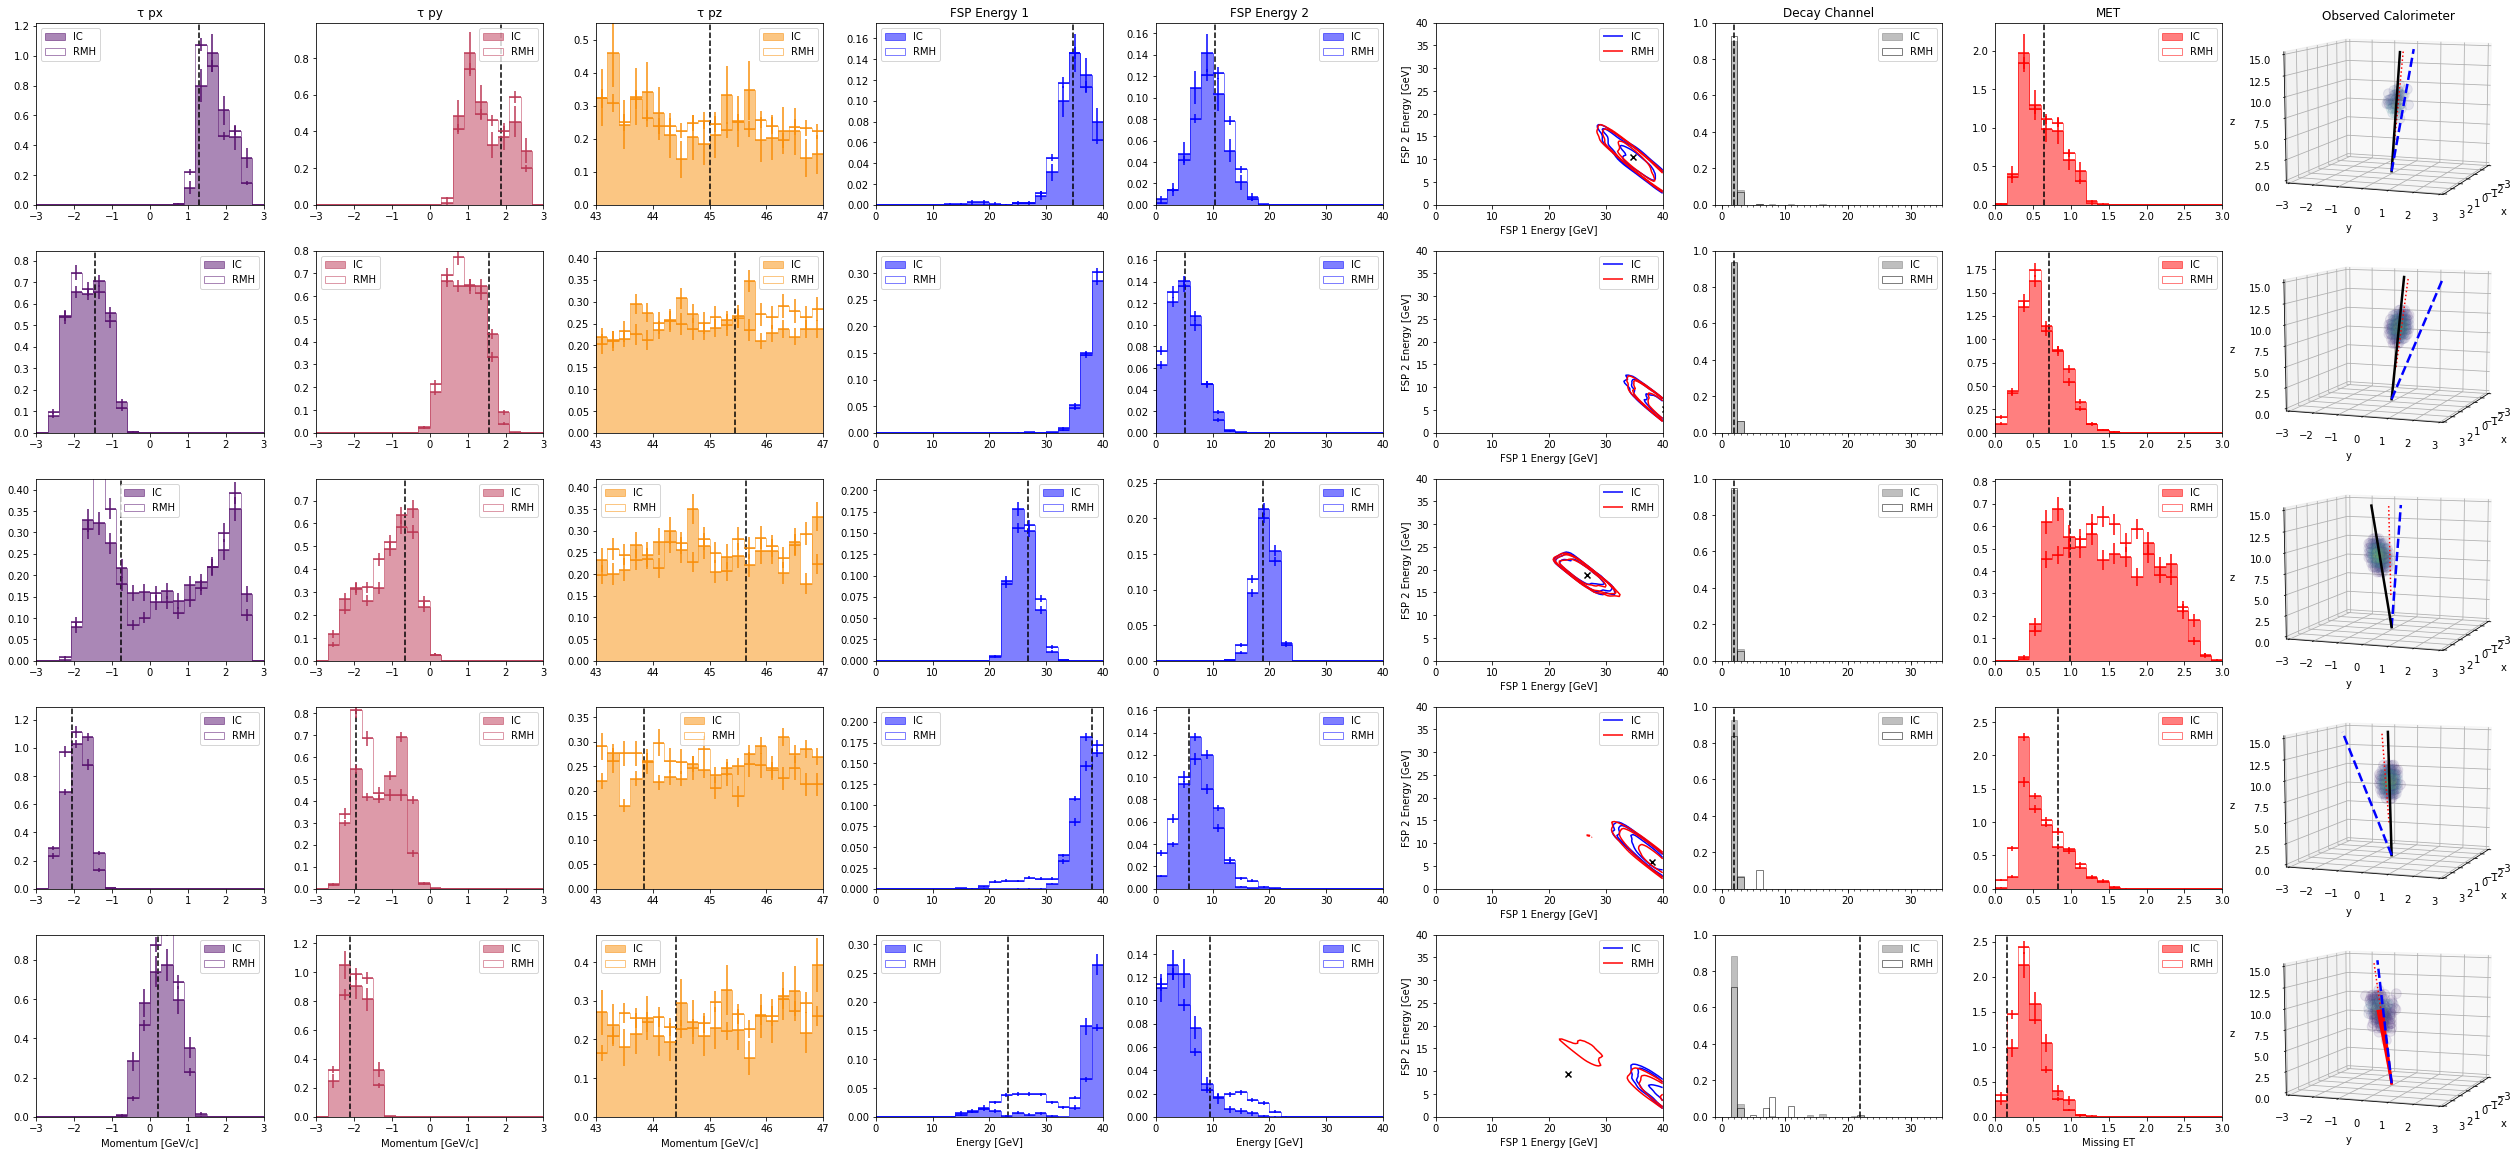

In [9]:
f = plt.figure()
f.set_size_inches(35,17)
shape = (5,9)
#for run in range(0,10):
plot_dist(chan=2,run=0,index=0)
plot_dist(chan=2,run=2,index=1)
plot_dist(chan=2,run=8,index=2)
plot_dist(chan=2,run=9,index=3)
plot_dist(chan=22,run=2,index=4)
#plot_dist(chan=22,run=3,index=5)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
f.savefig('eta_physics_multi_3D_5rows.pdf')

#removed 
#plot_dist(chan=2,run=4,index=2)
#plot_dist(chan=2,run=6,index=3)

/global/common/cori/software/python/3.6-anaconda-5.2/lib/python3.6/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


TypeError: 'NoneType' object is not subscriptable

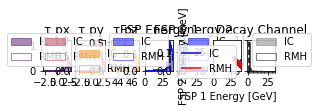

In [7]:
plot_dist(2)

In [ ]:
import matplotlib.pyplot as pl
import scipy.stats as st


def draw_contour(ax,datasets,color, style = 'dotted'):
    x = datasets[0]
    y = datasets[1]
    xmin, xmax = 0,40
    ymin, ymax = 0,40
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    cset = ax.contour(xx, yy, f, colors=color, levels = [2e-3,5e-3,2e-2], linestyles = style, alpha = 1.0)
    

fig = pl.figure()
ax = fig.gca()
draw_contour(ax, datasets = [energies[:,0,3],energies[:,1,3]], color = 'k')
draw_contour(ax, datasets = [energies_rmh[:,0,3],energies_rmh[:,1,3]], color = 'r')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('Y1')
ax.set_ylabel('Y0')

In [ ]:
plt.bar(np.arange(len(c)),c, yerr = np.sqrt(c)/np.sum(c)*500.)

In [ ]:
plt.hist(mother[:,3], bins = np.linspace(0,5,11))
plt.hist(mother_rmh[:,3], bins = np.linspace(0,5,11), alpha = 0.2)

In [ ]:

# plt.hist(energies[:,0,-1])

In [ ]:
# for event in final:
#     print(event)

In [ ]:
plt.hist(met, bins = np.linspace(0,20,11), alpha = 0.2)
plt.hist(met_rmh, bins = np.linspace(0,20,11), alpha = 0.2)
plt.savefig('ok.pdf')

In [ ]:
!open ok.pdf